# A modular version

written October 2016 by Sam Greydanus

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
import gym
import tensorflow as tf

In [2]:
class Actor():
    def __init__(self, n_obs, h, n_actions):
        self.n_obs = n_obs                  # dimensionality of observations
        self.h = h                          # number of hidden layer neurons
        self.n_actions = n_actions          # number of available actions
        
        self.model = model = {}
        with tf.variable_scope('actor',reuse=False):
            # convolutional layer 1
            self.model['Wc1'] = tf.Variable(tf.truncated_normal([5, 5, 2, 8], stddev=0.1))
            self.model['bc1'] = tf.Variable(tf.constant(0.1, shape=[8]))

            # convolutional layer 2
            self.model['Wc2'] = tf.Variable(tf.truncated_normal([5, 5, 8, 8], stddev=0.1))
            self.model['bc2'] = tf.Variable(tf.constant(0.1, shape=[8]))

            # fully connected 1
            self.model['W3'] = tf.Variable(tf.truncated_normal([14*10*8, 8], stddev=0.1))
            self.model['b3'] = tf.Variable(tf.constant(0.1, shape=[8]))

            # fully connected 2
            self.model['W4'] = tf.Variable(tf.truncated_normal([8, n_actions], stddev=0.1))
            self.model['b4'] = tf.Variable(tf.constant(0.1, shape=[n_actions]))
            
    def policy_forward(self, x):
        x_image = tf.reshape(x, [-1, 105, 80, 2])
                                      
        zc1 = tf.nn.conv2d(x_image, self.model['Wc1'], strides=[1, 1, 1, 1], padding='SAME') + self.model['bc1']
        hc1 = tf.nn.relu(zc1)
        hc1 = tf.nn.max_pool(hc1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
        
        zc2 = tf.nn.conv2d(hc1, self.model['Wc2'], strides=[1, 1, 1, 1], padding='SAME') + self.model['bc2']
        hc2 = tf.nn.relu(zc2)
        hc2 = tf.nn.max_pool(hc2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
        print hc2.get_shape()
        
        hc2_flat = tf.reshape(hc2, [-1, 14*10*8])
        h3 = tf.nn.relu(tf.matmul(hc2_flat, self.model['W3']) + self.model['b3'])
        h3 = tf.nn.dropout(h3, 0.9)
        
        h4 = tf.matmul(h3, self.model['W4']) + self.model['b4']
        return tf.nn.softmax(h4)

In [3]:
class Agent():
    def __init__(self, n_obs, n_actions, gamma=0.99, actor_lr = 1e-4, decay=0.95, epsilon = 0.1):
        self.gamma = gamma            # discount factor for reward
        self.epsilon = epsilon
        self.global_step = 0
        self.xs, self.rs, self.ys = [],[],[]
        
        self.actor_lr = actor_lr               # learning rate for policy
        self.decay = decay
        self.n_obs = n_obs                     # dimensionality of observations
        self.n_actions = n_actions             # number of available actions
        self.save_path ='models/pong.ckpt'
        
        # make actor part of brain
        self.actor = Actor(n_obs=self.n_obs, h=200, n_actions=self.n_actions)
        
        #placeholders
        self.x = tf.placeholder(dtype=tf.float32, shape=[None, n_obs],name="x")
        self.y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions],name="y")
        self.r = tf.placeholder(dtype=tf.float32, shape=[None,1], name="r")
        
        #gradient processing (PG magic)
        self.discounted_r = self.discount_rewards(self.r, self.gamma)
        mean, variance= tf.nn.moments(self.discounted_r, [0], shift=None, name="reward_moments")
        self.discounted_r -= mean
        self.discounted_r /= tf.sqrt(variance + 1e-6)
        
        # initialize tf graph
        self.aprob = self.actor.policy_forward(self.x)
        self.loss = tf.nn.l2_loss(self.y-self.aprob)
        self.optimizer = tf.train.RMSPropOptimizer(self.actor_lr, decay=self.decay)
        self.grads = self.optimizer.compute_gradients(self.loss, \
                                    var_list=tf.trainable_variables(), grad_loss=self.discounted_r)
        self.train_op = self.optimizer.apply_gradients(self.grads)

        self.sess = tf.InteractiveSession()
        tf.initialize_all_variables().run()
        self.saver = tf.train.Saver(tf.all_variables())
    
    def act(self, x):
        aprob = self.sess.run(self.aprob, {self.x: x})
        aprob = aprob[0,:]
        action = np.random.choice(self.n_actions,p=aprob) if np.random.rand() > self.epsilon else np.random.randint(self.n_actions)
        
        label = np.zeros_like(aprob) ; label[action] = 1
        self.xs.append(x)
        self.ys.append(label)
        
        return action
    
    def learn(self):
        epx = np.vstack(self.xs)
        epr = np.vstack(self.rs)
        epy = np.vstack(self.ys)
        self.xs, self.rs, self.ys = [],[],[] # reset game history
        
        feed = {self.x: epx, self.r: epr, self.y: epy}
        _ = self.sess.run(self.train_op,feed) # parameter update
        self.global_step += 1
        
    def try_load_model(self):
        load_was_success = True # yes, I'm being optimistic
        try:
            save_dir = '/'.join(self.save_path.split('/')[:-1])
            ckpt = tf.train.get_checkpoint_state(save_dir)
            load_path = ckpt.model_checkpoint_path
            self.saver.restore(self.sess, load_path)
        except:
            print "no saved model to load. starting new session"
            load_was_success = False
        else:
            print "loaded model: {}".format(load_path)
            self.saver = tf.train.Saver(tf.all_variables())
            self.global_step = int(load_path.split('-')[-1])
            
    def save(self):
        self.saver.save(self.sess, self.save_path, global_step=self.global_step)
        
    @staticmethod
    def discount_rewards(r, gamma):
        discount_f = lambda a, v: a*gamma + v;
        r_reverse = tf.scan(discount_f, tf.reverse(r,[True, False]))
        discounted_r = tf.reverse(r_reverse,[True, False])
        return discounted_r

In [4]:
# downsampling
def prepro(o):
    rgb = o
    gray = 0.3*rgb[:,:,0:1] + 0.4*rgb[:,:,1:2] + 0.3*rgb[:,:,2:3]
    gray = gray[::2,::2,:]
    gray -= np.mean(gray) ; gray /= 100
    return gray.astype(np.float)

def plt_dynamic(x, y, ax, colors=['b']):
    for color in colors:
        ax.plot(x, y, color)
    fig.canvas.draw()

In [5]:
# env = gym.make("Pong-v0")
# observation = env.reset()
# print prepro(observation).shape
# print 105*80

In [6]:
n_obs = 2*105*80   # dimensionality of observations
n_actions = 3
agent = Agent(n_obs, n_actions, gamma = 0.99, actor_lr=1e-3, decay=0.99, epsilon = 0.1)
agent.try_load_model()

env = gym.make("Pong-v0")
observation = env.reset()
cur_x = None
running_reward = -20.48 # usually starts around 10 for cartpole
reward_sum = 0
episode_number = agent.global_step

(?, 14, 10, 8)


[2016-10-22 17:41:04,195] Making new env: Pong-v0


In [7]:
total_parameters = 0 ; print "Model overview:"
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print '\tvariable "{}" has {} parameters' \
        .format(variable.name, variable_parameters)
    total_parameters += variable_parameters
print "Total of {} parameters".format(total_parameters)

Model overview:
	variable "actor/Variable:0" has 400 parameters
	variable "actor/Variable_1:0" has 8 parameters
	variable "actor/Variable_2:0" has 1600 parameters
	variable "actor/Variable_3:0" has 8 parameters
	variable "actor/Variable_4:0" has 8960 parameters
	variable "actor/Variable_5:0" has 8 parameters
	variable "actor/Variable_6:0" has 24 parameters
	variable "actor/Variable_7:0" has 3 parameters
Total of 11011 parameters


<IPython.core.display.Javascript object>


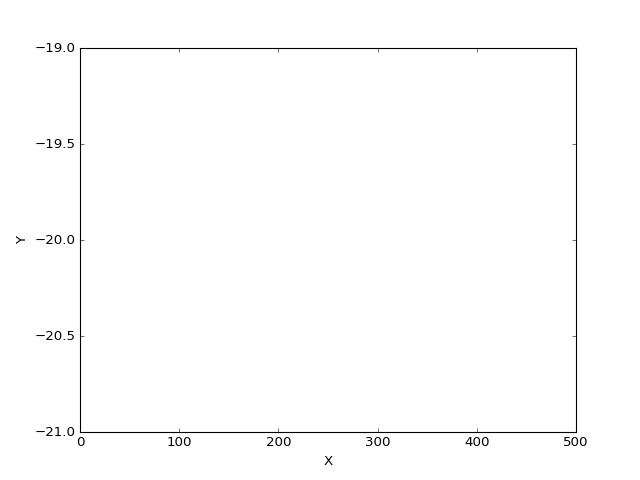

episode 0: starting up...
ep: 0, reward: -21.0, mean reward: -20.485200
	ep: 1, reward: -21.0
	[ 0.39974874  0.34618184  0.25406945]
	ep: 2, reward: -20.0
	[ 0.41074133  0.33646175  0.25279692]
	ep: 3, reward: -21.0
	[ 0.44916406  0.32183743  0.22899844]


KeyboardInterrupt: 

In [8]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('X') ; ax.set_ylabel('Y')
ax.set_xlim(0,500) ; ax.set_ylim(-21,-19)
pxs, pys = [], []

print 'episode {}: starting up...'.format(episode_number)
while True:
#     if episode_number%25==0: env.render()

    # preprocess the observation, set input to network to be difference image
    prev_x = cur_x if cur_x is not None else np.zeros((105,80,1))
    cur_x = prepro(observation)
    x = np.concatenate((cur_x, prev_x),axis=-1).ravel()

    # stochastically sample a policy from the network
    action = agent.act(np.reshape(x, (1,-1)))

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action + 1)
    agent.rs.append(reward)
    reward_sum += reward
    
    if done:
        running_reward = running_reward * 0.99 + reward_sum * 0.01
        agent.learn()

        # visualization
        pxs.append(episode_number)
        pys.append(running_reward)
        if episode_number % 10 == 0:
            print 'ep: {}, reward: {}, mean reward: {:3f}'.format(episode_number, reward_sum, running_reward)
            plt_dynamic(pxs, pys, ax)
        else:
            print '\tep: {}, reward: {}'.format(episode_number, reward_sum)
            feed = {agent.x: np.reshape(x, (1,-1))}
            aprob = agent.sess.run(agent.aprob, feed) ; aprob = aprob[0,:]
            print'\t', aprob
            
#         if episode_number % 50 == 0: agent.save() ; print "SAVED MODEL #{}".format(agent.global_step)
        
        # lame stuff
        cur_x = None
        episode_number += 1 # the Next Episode
        observation = env.reset() # reset env
        reward_sum = 0

In [9]:
def prepro(o):
    rgb = o
    gray = 0.3*rgb[:,:,0:1] + 0.4*rgb[:,:,1:2] + 0.3*rgb[:,:,2:3]
    gray = gray[::2,::2,:]
    gray -= np.mean(gray) ; gray /= 100
    return gray.astype(np.float)

In [10]:
print np.reshape(x, (1,-1)).shape
print agent.x.get_shape()
agent.act(np.reshape(x, (1,-1)))

(1, 16800)
(?, 16800)


0

In [11]:
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = prepro(observation)
observation, reward, done, info = env.step(2)
cur_x = prepro(observation)

[2016-10-22 17:42:26,845] Making new env: Pong-v0


(105, 80, 1)


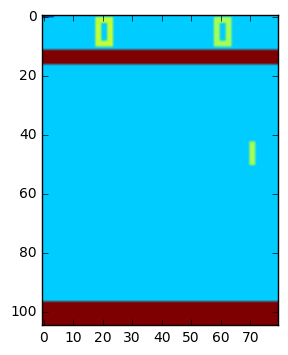

In [12]:
%matplotlib inline
print cur_x.shape
plt.imshow(cur_x[:,:,0])

In [13]:
x = np.concatenate((cur_x, prev_x),axis=-1).ravel()
print x.shape

(16800,)


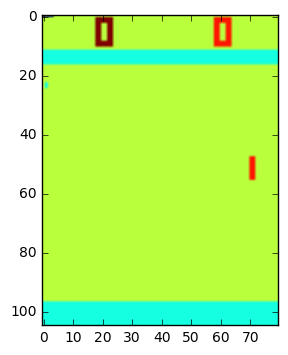

In [14]:
p = np.reshape(x,(-1,105,80,2))
plt.imshow(p[0,:,:,1])

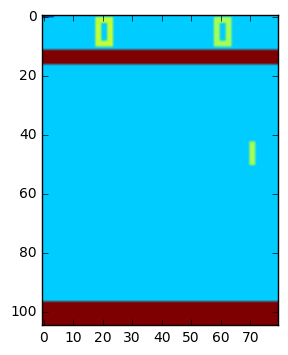

In [15]:
plt.imshow(p[0,:,:,0])